# Classify Catmon Image From Twitter Stream Using MOBILENET_V2 CNN Model

## Set-up

In [2]:
import importlib # required in jupyter notebook
import logging
importlib.reload(logging) # required in jupyter notebook

import matplotlib.pyplot as plt
import numpy as np
import os
import requests
import sys
import tweepy

from configparser import ConfigParser
from io import BytesIO
from PIL import Image

from catmonic_logger import logger

import torch
from torch import nn, optim
from torch.optim import lr_scheduler

from torchvision import datasets, transforms, models
import torchvision

In [3]:
print(f"tweepy version: {tweepy.__version__}")
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

tweepy version: 4.10.0
torch version: 1.10.0
torchvision version: 0.11.1


In [4]:
# define handler config
DO_TWEET_REPLY = False
print(f"do tweet reply is: {DO_TWEET_REPLY}")

do tweet reply is: False


In [5]:
# define key twitter info
BOOSIMBA_TWITTER_CONFIG_FILE = 'catmonic_twitter.ini' 
BOOSIMBA_TWITTER_USER_ID = 3022268453
print(f"boosimba titter config file is: {BOOSIMBA_TWITTER_CONFIG_FILE}")
print(f"boosimba twitter user id is: {BOOSIMBA_TWITTER_USER_ID}")

boosimba titter config file is: catmonic_twitter.ini
boosimba twitter user id is: 3022268453


In [6]:
# define model class names
CLASS_NAMES = ['boo', 'simba', 'unknown']
print(f"total of {len(CLASS_NAMES)} class names: {CLASS_NAMES}")

total of 3 class names: ['boo', 'simba', 'unknown']


In [7]:
# define image transform
# - as used during model transfer learning, training and test
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN,
                         std=STD)
])

In [8]:
# use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device is: {device}")

device is: cpu


In [9]:
# define model state dict containing key paramaters
MODEL_SD = "models/catmon-img-classifier_mobilenet_v2_state_dict_0.3"
print(f"model state dict location: {MODEL_SD}")

model state dict location: models/catmon-img-classifier_mobilenet_v2_state_dict_0.3


In [10]:
# define location of cat test images
BOO_IMAGE = "images/unseen_boo_image_2015-03-08_141742.jpg"
SIMBA_IMAGE = "images/unseen_simba_image_2015-05-10_180756.jpg"
UNKNOWN_IMAGE = "images/unseen_unknown_image_2015-05-10_044850.jpg"

## Prepare model, load the saved model params from state dict

In [11]:
def prepare_mobilenet_v2_model(class_names, model_sd):
    """Prepare mobilenet_v2 model for evaluation."""

    # instantiate the model
    model = models.mobilenet_v2()

    # extract number of input and output features from the model
    num_features = model.classifier[-1].in_features

    # update model classifier to take account of number of classes
    num_classes = len(class_names)
    model.classifier[-1] = nn.Linear(num_features, num_classes)

    # load state dict for the trained model
    model.load_state_dict(torch.load(model_sd))
    
    # place model in evaluation mode
    model.eval()
    
    return model

In [12]:
model = prepare_mobilenet_v2_model(CLASS_NAMES, MODEL_SD)

In [13]:
# check modified classifier (expect in_features=num_features and out_features=num_classes)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [14]:
model

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

## Check model prediction with new catmon images

In [15]:
# define helper function to show given input tensor
def imshow(inp, title):
    """Show given image (in inp tensor) with title, using matplotlib."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    inp = STD * inp + MEAN
    inp = np.clip(inp, 0, 1)
    
    plt.figure (figsize = (12, 6))
    
    plt.imshow(inp)
    plt.title(title)
    plt.pause(1)

In [16]:
# define helper function to predict catmon image
def predict_catmon_image(model, class_names, transform, device, pil_image, display=True):
    """Return predicted label and probability for given model and pil image.
    
    If display is True,
    Display image with predicted label and probability percentage, 
    
    """
    
    # apply transform to create the required tensor
    tensor = transform(pil_image)
    
    # reshape tensor to add dummy batch
    reshaped_tensor = tensor.unsqueeze(0)
    print(reshaped_tensor.shape)
    
    # classify the image
    with torch.no_grad():

        inputs = reshaped_tensor.to(device)
        outputs = model(inputs)
        probs, preds = torch.max(outputs, 1)

        # calculate probabilities using softmax
        sm = torch.nn.Softmax(dim=1)
        probabilities = sm(outputs).flatten().numpy()
        print(preds, probabilities)
        
        label = class_names[preds]
        probability = float(probabilities[preds])
        print(label, probability)

    if display:
        img = inputs.data[0]
        imshow(img, f"predicted: {label} ({probability:.2%})")
    
    return label, probability

torch.Size([1, 3, 224, 224])
tensor([0]) [1.0000000e+00 1.1024577e-11 2.7971856e-08]
boo 1.0


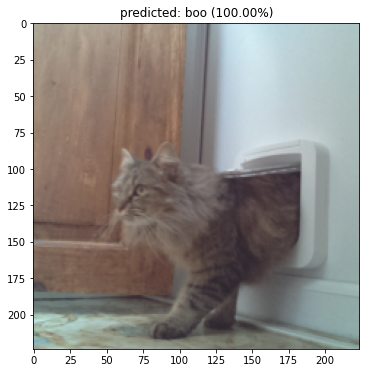

Wall time: 2.25 s


In [17]:
%%time
# test model prediction with boo image
# first convert jpg to pil
pil_image = Image.open(BOO_IMAGE)
# predict
label, probability = predict_catmon_image(model, CLASS_NAMES, transform, device, pil_image, display=True)
assert label == 'boo' and probability > 0.99, "unexepected error with prediction"

torch.Size([1, 3, 224, 224])
tensor([1]) [1.2509234e-20 1.0000000e+00 1.8789678e-14]
simba 1.0


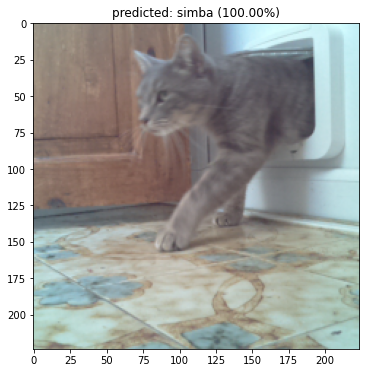

Wall time: 1.99 s


In [18]:
%%time
# test model prediction with simba image
# first convert jpg to pil
pil_image = Image.open(SIMBA_IMAGE)
# predict
label, probability = predict_catmon_image(model, CLASS_NAMES, transform, device, pil_image, display=True)
assert label == 'simba' and probability > 0.99, "unexepected error with prediction"

torch.Size([1, 3, 224, 224])
tensor([2]) [1.3427177e-05 3.4613245e-07 9.9998617e-01]
unknown 0.9999861717224121


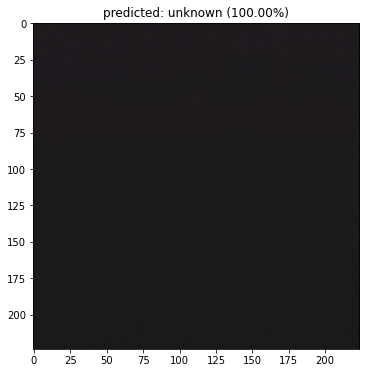

Wall time: 1.91 s


In [19]:
%%time
# test model prediction with simba image
# first convert jpg to pil
pil_image = Image.open(UNKNOWN_IMAGE)
# predict
label, probability = predict_catmon_image(model, CLASS_NAMES, transform, device, pil_image, display=True)
assert label == 'unknown' and probability > 0.99, "unexepected error with prediction"

## Prepare twitter access

In [20]:
# define helper function to read auth info from ini file
# ref: Explore Twitter API
def get_auth_info(TWITTER_CONFIG_FILE):
    """Return twitter account name and auth info for twitter access."""
 
    config_path = os.path.abspath(TWITTER_CONFIG_FILE)

    if not os.path.exists(config_path):
        raise FileNotFoundError(
            f"Unexpected error, file not found: '{TWITTER_CONFIG_FILE}'"
        )

    # parse the config file and read key twitter info
    cfg = ConfigParser()
    cfg.read(config_path)

    account_name = cfg.get('twitter', 'account_name') 
    consumer_key = cfg.get('twitter', 'consumer_key')
    consumer_secret = cfg.get('twitter', 'consumer_secret')
    access_token = cfg.get('twitter', 'access_token')
    access_token_secret = cfg.get('twitter', 'access_token_secret')
    
    auth_info = (
        consumer_key,
        consumer_secret,
        access_token,
        access_token_secret
    )
    
    return account_name, auth_info

In [21]:
# get twitter account name and auth info
account_name, auth_info = get_auth_info(BOOSIMBA_TWITTER_CONFIG_FILE)
assert account_name == 'boosimba', f"Unexpected error, account_name '{account_name}' not recognised"

In [22]:
# use auth info to establish api
auth = tweepy.OAuth1UserHandler(*auth_info)
api = tweepy.API(auth)

In [23]:
# test api, get the user object for boosimba...
user = api.get_user(screen_name=account_name)

# show user id and location
user_id = user.id
user_location = user.location
print(f"user id is: {user_id}, user location is: {user_location}")
assert user_id == BOOSIMBA_TWITTER_USER_ID and user_location == 'UK', "Unexpected error reading twitter user location"

user id is: 3022268453, user location is: UK


In [24]:
# define helper function to reply to a tweet
# ref: Explore Twitter API
def reply_to_tweet(api, id, text):
    """Use api to reply to given tweet id with given text."""

    try:
        api.update_status(
                status = text, 
                in_reply_to_status_id = id, 
                auto_populate_reply_metadata=True
        )
    except TypeError as e:
        print(f"Unexpected error replying on given api to tweet id {id} with text ''{text}' (error={e}, type={type(e)}")
        raise
        
def get_tweet_thread(api, username, id):
    replies = tweepy.Cursor(
        api.search_tweets, 
        q='to:{}'.format(username),
        since_id=id, 
        tweet_mode='extended'
    ).items()
    
    replied_thread = list()
    for reply in replies:
        if(reply._json['in_reply_to_status_id'] == id):
             replied_thread.append(reply._json['full_text'])
        
    return(replied_thread)

In [25]:
# test with reply to tweet containing 'Boo chased a fox!'
# https://stackoverflow.com/questions/9322465/reply-to-tweet-with-tweepy-python
TWEET_REPLY = True
TWEET_ID = 1541050269101858816
TWEET_TEXT = 'Simba ran away'
if not TWEET_REPLY:
    reply_to_tweet(api, TWEET_ID, TWEET_TEXT)
else:
    print('already replied')

already replied


In [26]:
# show reply (will be empty if too old)
get_tweet_thread(api, 'boosimba', TWEET_ID)

[]

In [27]:
# show most recent tweet
last_tweet = api.user_timeline(user_id=user_id, screen_name=account_name, count=1)[0] # Get the last tweet
print(f"last tweet created at: {last_tweet.created_at}")
print(f"last tweet text: {last_tweet.text}") 

last tweet created at: 2022-08-17 06:30:15+00:00
last tweet text: Hello Boo

[probability: 100.0%, image automatically identified by the catmon image classifier cnn, using MobileNetV2]


In [28]:
last_tweet

Status(_api=<tweepy.api.API object at 0x0000027A64B0D1F0>, _json={'created_at': 'Wed Aug 17 06:30:15 +0000 2022', 'id': 1559789685244829699, 'id_str': '1559789685244829699', 'text': 'Hello Boo\n\n[probability: 100.0%, image automatically identified by the catmon image classifier cnn, using MobileNetV2]', 'truncated': False, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': []}, 'source': '<a href="http://terrysmusings.blogspot.co.uk/2015/03/catmon.html" rel="nofollow">catflapmon</a>', 'in_reply_to_status_id': 1559789106720395264, 'in_reply_to_status_id_str': '1559789106720395264', 'in_reply_to_user_id': 3022268453, 'in_reply_to_user_id_str': '3022268453', 'in_reply_to_screen_name': 'boosimba', 'user': {'id': 3022268453, 'id_str': '3022268453', 'name': 'boosimba', 'screen_name': 'boosimba', 'location': 'UK', 'description': 'Two cool #cats who like to tweet. Boo is fluffy and stays close to home. Simba comes home when hungry. Read about catmon on blog below. Now wi

In [29]:
last_tweet.entities

{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': []}

## Define and run tweet handler to classify boosimba catmon images
- on boosimba catmon tweet, classify associated image and post reply with cat label (if known)
- ref:
 - https://stackoverflow.com/questions/22675561/using-tweepy-to-stream-users-timeline-and-filtered-tweets
 - https://web.archive.org/web/20140704092006/http://answers.oreilly.com/topic/2605-how-to-capture-tweets-in-real-time-with-twitters-streaming-api

In [30]:
# define stream handler helper function
class BooSimbaTweetHandler(tweepy.Stream):
    
    def __init__(
            self, 
            model, 
            transform, 
            device, 
            class_names,
            do_tweet_reply,
            *auth_info, 
            **kwargs
    ):
        model_name = model.__class__.__name__
        logger.info(
            f"Initialise handler with given model (name={model_name}), "
            f"transform, device ({device}), class_names ({class_names}) " 
            f"do_tweet_reply ({do_tweet_reply}) and set-up twitter api "
            f"using given auth_info"
        )
        self.model = model
        self.model_name = model_name
        self.transform = transform
        self.device = device
        self.class_names = class_names
        self.do_tweet_reply = do_tweet_reply
        auth = tweepy.OAuth1UserHandler(*auth_info)
        self.api = tweepy.API(auth)
        super().__init__(*auth_info, **kwargs)
        
    def _predict_catmon_image(
            self, 
            model, 
            transform, 
            device, 
            class_names, 
            pil_image):
        """Transform pil image, apply classification model and return 
        predicted label and probability."""
        
        # apply transform to create the required tensor
        tensor = transform(pil_image)

        # reshape tensor to add dummy batch
        reshaped_tensor = tensor.unsqueeze(0)
                     
        # classify the image
        with torch.no_grad():
            inputs = reshaped_tensor.to(device)
            outputs = model(inputs)
            probs, preds = torch.max(outputs, 1)

            # calculate probabilities using softmax
            sm = torch.nn.Softmax(dim=1)
            probabilities = sm(outputs) 

            label = class_names[preds]
            probability = float(probabilities.flatten()[preds])
            
        return label, probability
          
    def _image_download(self, media_url):
        """Return downloaded pil image at given media_url."""
        response = requests.get(media_url)
        pil_img = Image.open(BytesIO(response.content))
        
        return pil_img
    
    def _reply_to_tweet(self, api, id, text):
        """Use api to post text as reply to tweet with given id."""
        try:
            api.update_status(
                    status = text, 
                    in_reply_to_status_id = id, 
                    auto_populate_reply_metadata=True
            )
        except TypeError as e:
            logger.error(
                f"Unexpected error replying on given api to tweet id {id} "
                f"with text '{text}' (error={e}, type={type(e)}"
            )
            raise

    def _handle_tweet(self, tweet):
        """Classify image in boosimba catmon auto-tweet."""
        logger.info(
            f"New tweet detected from {tweet.user.name} (user "
            f"id={tweet.user.id}) --------------------"
        )
        # logger.debug(tweet)
        BOOSIMBA_TWITTER_USER_ID = 3022268453
        BOOSIMBA_AUTOTWEET_TEXT = 'auto-tweet from catmon'
        BOOSIMBA_CAT_LABELS = ['boo', 'simba'] # excludes the 'unknown' label
        
        # get full text (in a different place if tweet is extended)
        if 'extended_tweet' in tweet._json:
            logger.debug('extended tweet')
            tweet_text = tweet.extended_tweet['full_text']
        else:
            tweet_text = tweet.text
            
        # create a single line of text, replacing \n
        tweet_text_sl = tweet_text.replace('\n', ' ') 
        
        logger.info(f"Tweet text: {tweet_text_sl} (tweet id={tweet.id})")
            
        if tweet.user.id == BOOSIMBA_TWITTER_USER_ID and \
            tweet_text.startswith(BOOSIMBA_AUTOTWEET_TEXT):
            # all catmon auto-tweets should have an image, let's classify
            logger.info("Download image and classify...")
            try:
                # get media_url (in a different place if tweet is extended)
                if 'extended_tweet' in tweet._json:
                    media_url = tweet\
                        .extended_tweet['entities']['media'][0]['media_url']
                else:
                    media_url = tweet.entities['media'][0]['media_url']
                    
                pil_image = self._image_download(media_url)

                # display half-size image (useful if running in jupyter)
                # w, h = pil_image.size
                # display(pil_image.resize((int(w/2), int(h/2))))

                # classify the image
                label, proba = self._predict_catmon_image(
                    self.model, 
                    self.transform, 
                    self.device, 
                    self.class_names, 
                    pil_image
                )
                logger.info(
                    f"Classification: label={label}, probability={proba}"
                )
                
                if label in BOOSIMBA_CAT_LABELS:
                    reply_text = (
                        f"Hello {label.capitalize()}\n\n\n"
                        f"[probability: {proba:.2%}, image automatically "
                        f"identified by the catmon image classifier cnn, "
                        f"using {self.model_name}]"
                    )
                    
                    # create a single line of text, replacing \n
                    reply_text_sl = reply_text.replace('\n', ' ')
                    
                    logger.info(f"Tweet reply text: {reply_text_sl}")
                    if self.do_tweet_reply:
                        self._reply_to_tweet(self.api, tweet.id, reply_text)
                    else:
                        logger.info("Tweeting of replies is switched off")
                        
                else: # label is 'unknown'
                    logger.info("Cat cannot be identified")
            except KeyError:
                logger.error("Unexpected error, could not access media")
        else:
            logger.info(
                "No action required, the tweet is not an auto-tweet from "
                "catmon (probably a reply)"
            )
        
    def on_status(self, tweet):
        self._handle_tweet(tweet)
        
    def on_error(self, status_code):
        logger.error(f"Error detected: {status_code}")
        return True # Don't kill the stream

    def on_timeout(self):
        logger.warning("Timeout detected")
        return True # Don't kill the stream

In [31]:
# get twitter account name and auth info
account_name, auth_info = get_auth_info(BOOSIMBA_TWITTER_CONFIG_FILE)
assert account_name == 'boosimba', f"Unexpected error, account_name '{account_name}' not recognised"

# instantiate the boosimba tweet stream handler to classify the 
# catmon auto-tweet images
boosimba_tweet_handler = BooSimbaTweetHandler(
    model, 
    transform, 
    device, 
    CLASS_NAMES,
    DO_TWEET_REPLY,
    *auth_info
)

# run the handler, following the boosimba id
logger.info(f"Starting boosimba tweet handler (filter follow id is: {BOOSIMBA_TWITTER_USER_ID})...")
boosimba_tweet_handler.filter(follow=[BOOSIMBA_TWITTER_USER_ID])

2022-08-17 12:16:54,830 - INFO - Initialise handler with given model (name=MobileNetV2), transform, device (cpu), class_names (['boo', 'simba', 'unknown']) do_tweet_reply (False) and set-up twitter api using given auth_info
2022-08-17 12:16:54,832 - INFO - Starting boosimba tweet handler (filter follow id is: 3022268453)...


KeyboardInterrupt: 

In [ ]:
from catmonic_logger import LOGFILE
print(f"log file is: {LOGFILE}")

In [ ]:
!type {LOGFILE}